In [3]:
%notebook matplotlib
import pandas as pd
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
from datetime import datetime as dt


# LOAD DATA
-------------------------

In [4]:
df = pd.read_csv('sentiment.csv', usecols=[1,7,8,9,10])
df.Date = pd.to_datetime(df.Date)
df.Date = df.Date.dt.date
df = df.set_index(pd.DatetimeIndex(df.Date))
print(df.shape)
df.sort_index().head(10)

(285, 5)


,Date,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,,
2013-12-19,2013-12-19,0.140625,-0.020833,0,0
2017-05-16,2017-05-16,0.171875,-0.048611,1,0
2017-05-26,2017-05-26,0.461538,-0.004525,1,0
2017-06-07,2017-06-07,0.181159,-0.007246,0,0
2017-06-21,2017-06-21,0.149733,-0.085561,1,0
2017-07-21,2017-07-21,0.615385,0.000000,1,0
2017-08-02,2017-08-02,0.181185,-0.074332,0,0
2017-08-04,2017-08-04,0.168038,-0.105758,0,0
2017-08-07,2017-08-07,0.071023,-0.102273,0,0


In [5]:
df = df.groupby('Date').mean()
print(df.shape)
df.head(10)

(140, 4)


C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative
Date,,,,
2013-12-19,0.140625,-0.020833,0.0,0.0
2017-05-16,0.171875,-0.048611,1.0,0.0
2017-05-26,0.461538,-0.004525,1.0,0.0
2017-06-07,0.181159,-0.007246,0.0,0.0
2017-06-21,0.149733,-0.085561,1.0,0.0
2017-07-21,0.615385,0.000000,1.0,0.0
2017-08-02,0.181185,-0.074332,0.0,0.0
2017-08-04,0.168038,-0.105758,0.0,0.0
2017-08-07,0.071023,-0.102273,0.0,0.0


In [44]:
df2 = pd.read_csv('historical_pricing.csv', header = [0,1]).rename(columns = {'Unnamed: 0_level_1':'Date'}).iloc[1:,:]
df2 = df2.set_index(pd.DatetimeIndex(df2.Coin.Date))
df2.head()


Coin      XRP                                          \
                  Date Change %    High     Low    Open   Price    Vol.   
Date                                                                      
2017-08-01  2017-08-01    9.57%  0.1850  0.1585  0.1630  0.1786  26.82M   
2017-08-02  2017-08-02   -4.59%  0.1800  0.1680  0.1786  0.1704  11.47M   
2017-08-03  2017-08-03    2.46%  0.1772  0.1688  0.1704  0.1746   4.59M   
2017-08-04  2017-08-04   -0.57%  0.1780  0.1710  0.1746  0.1736   7.21M   
2017-08-05  2017-08-05    5.99%  0.1920  0.1710  0.1736  0.1840  20.38M   

                BTC                                              ETH          \
           Change %    High     Low    Open   Price    Vol. Change %    High   
Date                                                                           
2017-08-01   -4.37%  2901.6  2615.8  2854.3  2731.2  42.31K   12.53%  232.59   
2017-08-02   -1.07%  2757.8  2640.0  2733.8  2702.0  23.76K   -3.53%  229.70   
2017-08-03    3.27%  2813.0  2698.0  2702.0  2790.3  16.86K    3.11%  228.20   
2017-08-04    2.50%  2874.8  2762.6  2790.3  2860.0  18.99K   -1.81%  228.30   
2017-08-05   13.86%  3331.9  2855.0  2860.0  3256.4  50.56K   15.01%  259.90   

                                             
               Low    Open   Price     Vol.  
Date                                         
2017-08-01  200.80  200.81  225.97  352.31K  
2017-08-02  215.00  225.97  218.00  159.47K  
2017-08-03  217.07  218.00  224.79   96.19K  
2017-08-04  218.66  224.79  220.73   83.46K  
2017-08-05  219.23  220.73  253.87  234.87K

# EDA

First let's check and see if there are any strong correlations between XRP price and all other price values as displayed in the table above

In [7]:
corr_matrix = df2.corr()
corr_matrix.XRP.Price

XRP  High     0.994777
     Low      0.990348
     Open     0.985908
     Price    1.000000
BTC  High     0.694890
     Low      0.701030
     Open     0.703973
     Price    0.693918
ETH  High     0.863066
     Low      0.862218
     Open     0.849802
     Price    0.870301
Name: Price, dtype: float64

As we can see above, there's a good amount of correlation between XRP price and all the other price values. From the XRP standpoint, there's a higher correlation between intra day price and its intra day HIGH price. From ETH, the highest correlation between XRP price and ETH is from ETH's intra day trading price. And finally, with BTC - bitcoin, surpisingly the correlation isn't as strong as ETH since BTC is predominantly used to purchase XRP, but its highest correlation with XRP price is BTC open price. Let's now do some analysis on how XRP price fairs with our article sentiment. 

### Merge Article Sentiment DF with XRP prices

In [106]:
df3 = pd.merge(df,df2, how = 'outer', left_index = True, right_index = True).iloc[:,[0,1,2,3,4,5,9]].replace(np.NaN,0)
df3[('XRP', 'Change %')] = pd.to_numeric(df3[('XRP', 'Change %')].str.replace('%','')).replace(np.NaN,0)
df3.head(10)

C:\Users\simskel\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative,"(Coin, Date)","(XRP, Change %)","(XRP, Price)"
Date,,,,,,,
2013-12-19,0.140625,-0.020833,0.0,0.0,0,0.00,0.0000
2017-05-16,0.171875,-0.048611,1.0,0.0,0,0.00,0.0000
2017-05-26,0.461538,-0.004525,1.0,0.0,0,0.00,0.0000
2017-06-07,0.181159,-0.007246,0.0,0.0,0,0.00,0.0000
2017-06-21,0.149733,-0.085561,1.0,0.0,0,0.00,0.0000
2017-07-21,0.615385,0.000000,1.0,0.0,0,0.00,0.0000
2017-08-01,0.000000,0.000000,0.0,0.0,2017-08-01,9.57,0.1786
2017-08-02,0.181185,-0.074332,0.0,0.0,2017-08-02,-4.59,0.1704
2017-08-03,0.000000,0.000000,0.0,0.0,2017-08-03,2.46,0.1746


In [107]:
corr_matrix2 = df3.corr()
print(corr_matrix2[('XRP', 'Price')])
print('\n')
print(corr_matrix2[('XRP','Change %')])



Positive Sentiment    0.328162
Negative Sentiment   -0.185580
Headline Positive     0.226662
Headline Negative    -0.287400
(XRP, Change %)       0.064804
(XRP, Price)          1.000000
Name: (XRP, Price), dtype: float64


Positive Sentiment    0.267732
Negative Sentiment    0.084031
Headline Positive     0.350624
Headline Negative     0.122349
(XRP, Change %)       1.000000
(XRP, Price)          0.064804
Name: (XRP, Change %), dtype: float64


In [108]:
df3['% Change Binned'],bins = pd.cut(df3[('XRP','Change %')], bins = 20, labels = range(20),retbins=True)
print(bins)
df3.head(10)

[-31.07211 -25.3545  -19.749   -14.1435   -8.538    -2.9325    2.673
   8.2785   13.884    19.4895   25.095    30.7005   36.306    41.9115
  47.517    53.1225   58.728    64.3335   69.939    75.5445   81.15   ]


,Positive Sentiment,Negative Sentiment,Headline Positive,Headline Negative,"(Coin, Date)","(XRP, Change %)","(XRP, Price)",% Change Binned
Date,,,,,,,,
2013-12-19,0.140625,-0.020833,0.0,0.0,0,0.00,0.0000,5
2017-05-16,0.171875,-0.048611,1.0,0.0,0,0.00,0.0000,5
2017-05-26,0.461538,-0.004525,1.0,0.0,0,0.00,0.0000,5
2017-06-07,0.181159,-0.007246,0.0,0.0,0,0.00,0.0000,5
2017-06-21,0.149733,-0.085561,1.0,0.0,0,0.00,0.0000,5
2017-07-21,0.615385,0.000000,1.0,0.0,0,0.00,0.0000,5
2017-08-01,0.000000,0.000000,0.0,0.0,2017-08-01,9.57,0.1786,7
2017-08-02,0.181185,-0.074332,0.0,0.0,2017-08-02,-4.59,0.1704,4
2017-08-03,0.000000,0.000000,0.0,0.0,2017-08-03,2.46,0.1746,5


In [109]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

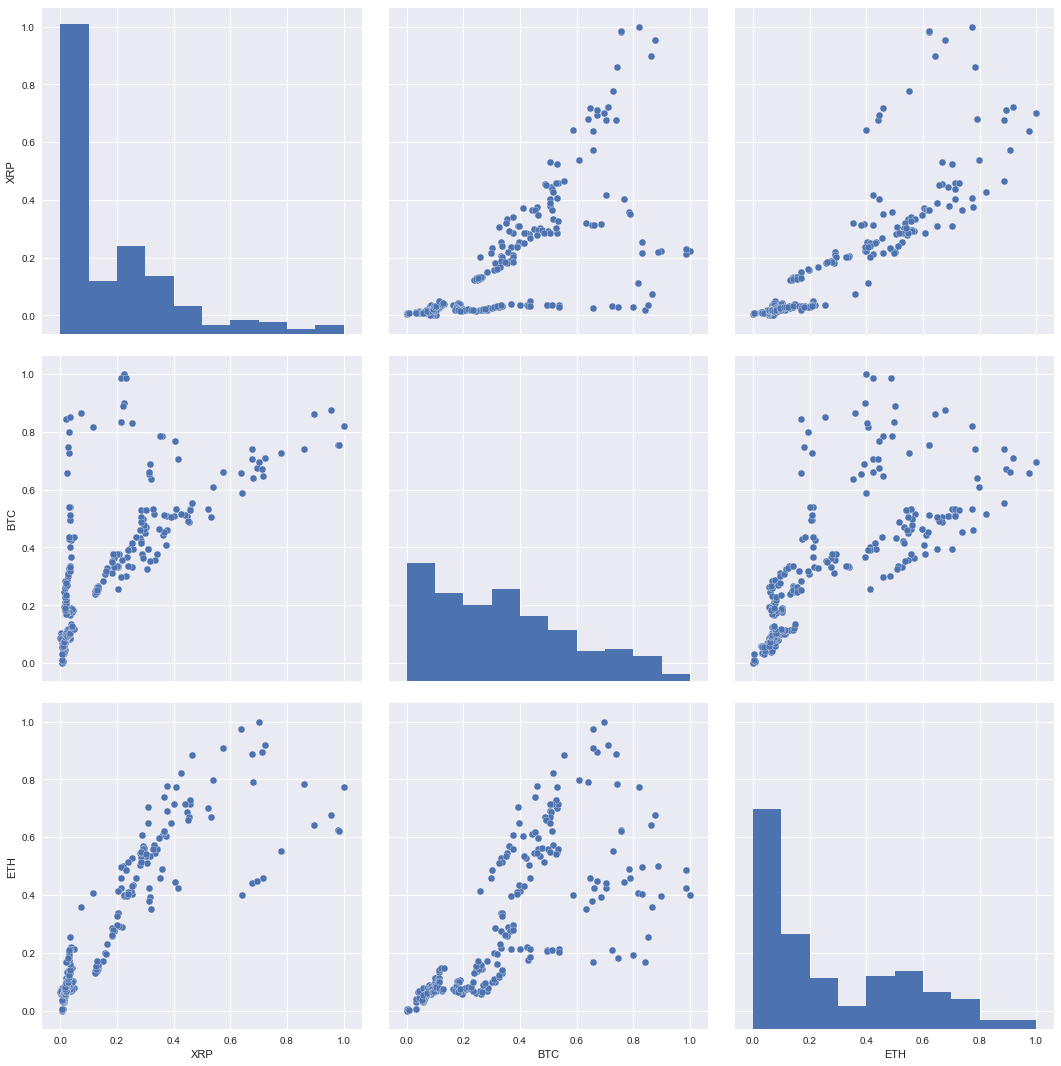

In [110]:
prices = df2.iloc[:,[5,11,17]]
scaler.fit(prices)
prices_scaled = scaler.transform(prices)
scaled_prices = pd.DataFrame(prices_scaled, columns = ['XRP','BTC','ETH'])
sns.pairplot(scaled_prices, size = 5)
plt.show()

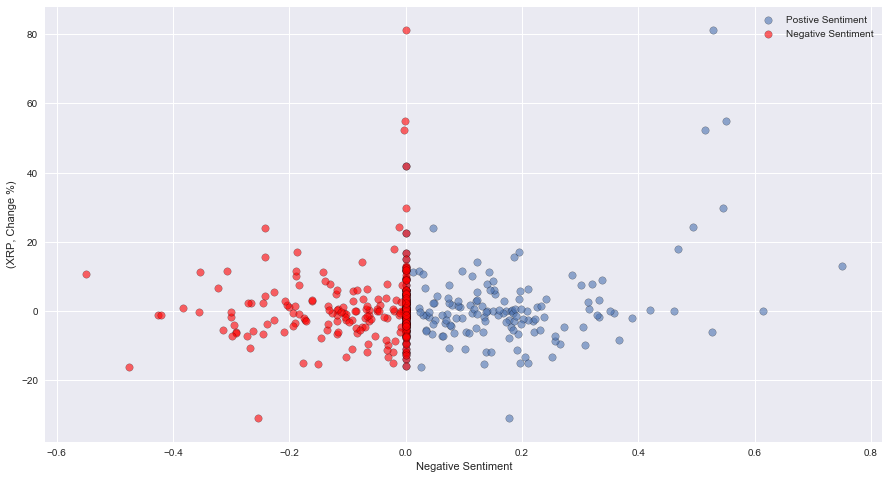

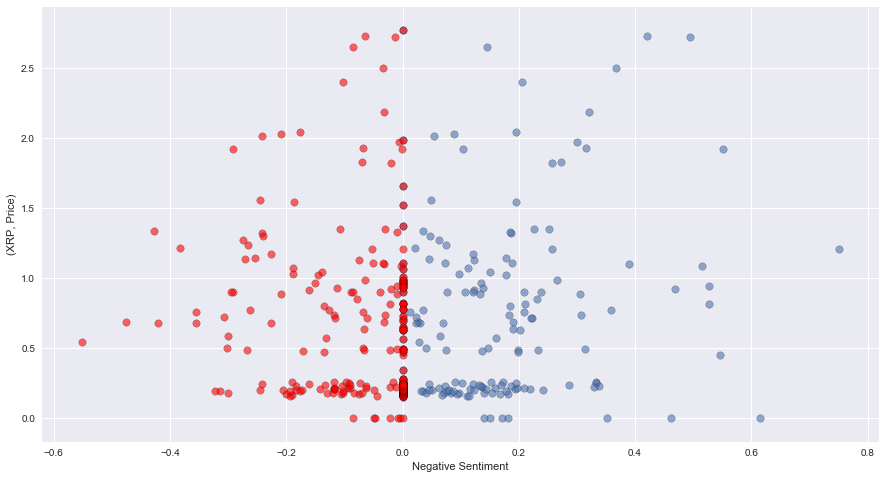

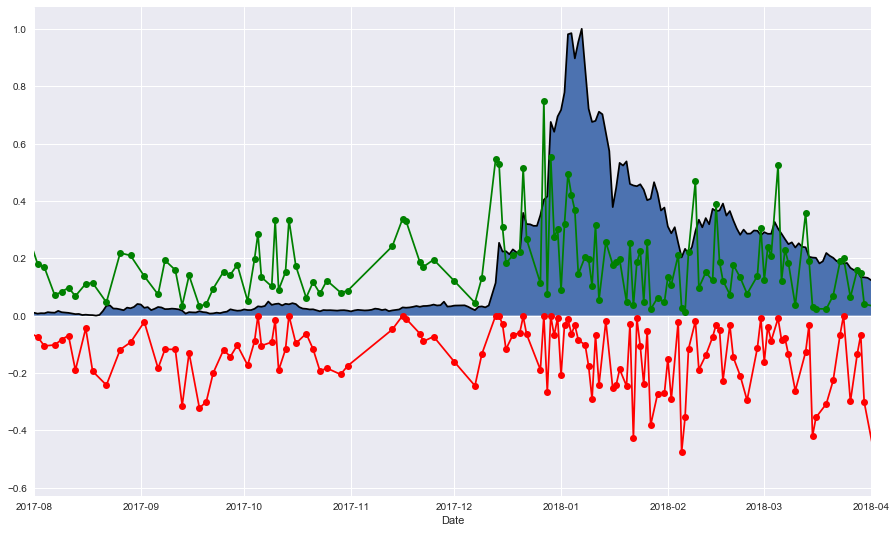

In [126]:

ax = df3.plot(x = 'Positive Sentiment', y = ('XRP', 'Change %'), kind = 'scatter', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3.plot(x = 'Negative Sentiment', y = ('XRP','Change %'), kind = 'scatter', color = 'red', ax = ax, alpha = 0.6, edgecolors='k', s=55)
plt.legend(['Postive Sentiment', 'Negative Sentiment'])
ax2 = df3.plot(x = 'Positive Sentiment', y = ('XRP', 'Price'), kind = 'scatter', figsize = (15,8), alpha = 0.6, edgecolors='k',s=55)
df3.plot(x = 'Negative Sentiment', y = ('XRP','Price'), kind = 'scatter', color = 'red', ax = ax2, alpha = 0.6, edgecolors='k', s=55)
plt.show()

fig = plt.figure(figsize=(15,9))
plt.fill_between(df2.index,np.zeros(len(scaled_prices.XRP)),scaled_prices.XRP,interpolate = True)
plt.plot(df2.Coin.Date, scaled_prices.XRP, color = 'k')
df['Positive Sentiment'].plot(marker = 'o', linestyle = '-', color = 'green')
df['Negative Sentiment'].plot(marker = 'o', linestyle = '-', color = 'red')

x = ['2017-08','2018-04']


plt.xlim(x)
plt.show()

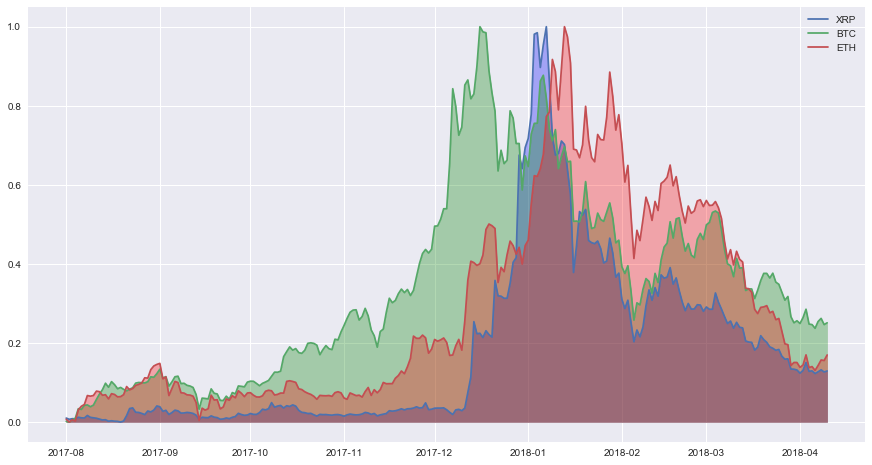

In [111]:
fig = plt.figure(figsize=(15,8))
plt.plot(df2.index, scaled_prices.XRP)
plt.fill_between(df2.index,0,scaled_prices.XRP, color = 'blue', alpha = 0.3)
plt.plot(df2.index, scaled_prices.BTC)
plt.fill_between(df2.index,0,scaled_prices.BTC, color = 'green', alpha = 0.3)
plt.plot(df2.index, scaled_prices.ETH)
plt.fill_between(df2.index,0,scaled_prices.ETH, color = 'red', alpha = 0.3)
plt.legend(['XRP','BTC','ETH'])
plt.show()

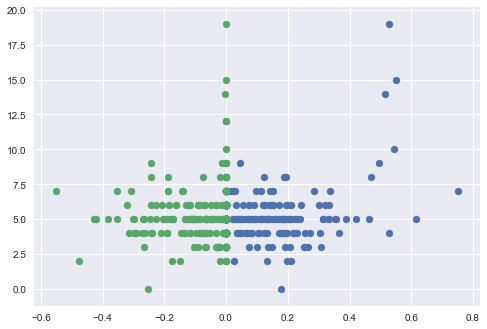

In [125]:
plt.scatter(df3['Positive Sentiment'],df3['% Change Binned'])
plt.scatter(df3['Negative Sentiment'],df3['% Change Binned'])
plt.show()